# Timescales of SIT Variability

## Background and Motivation

## Goals

## Functions

In [1]:
import xarray as xr
from functools import partial
import matplotlib.pyplot as plt
import glob
import scipy.signal as signal
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib
# from pathos.multiprocessing import ProcessingPool as Pool
import time

# # Import dask
# import dask
# # Use dask jobqueue
# from dask_jobqueue import PBSCluster
# # Import a client
# from dask.distributed import Client

### Data Reading

In [2]:
# def read_cesmLE(variable, time_int):
#     """ Read in CESM2 Large ensemble data. Returns an array that is ensemble member x time x space"""

#     arrays = []
#     decades = ['185001-185912','186001-186912','187001-187912','188001-188912','189001-189912',
#                '190001-190912','191001-191912','192001-192912','193001-193912','194001-194912',
#                '195001-195912','196001-196912','197001-197912','198001-198912','199001-199912',
#                '200001-200912','201001-201412','201501-202412','202501-203412','203501-204412',
#                '204501-205412','205501-206412','206501-207412','207501-208412','208501-209412',
#                '209501-210012']
#     for d in decades:
#         files = sorted(glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/ice/proc/tseries/'+time_int+'_1/'+variable+'/b.e21.*[0-9]*.{}.nc'.format(d)))
#         # print(len(files))
#         array_group = xr.open_mfdataset(files, combine='nested', concat_dim='member', parallel=True)

#         arrays.append(array_group)

#     final_array = xr.concat(arrays, dim = 'time')

#     return final_array


# def combine_files(time_int, variable, d):

#     tag = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/ice/proc/tseries/'+time_int+'_1/'+variable+'/b.e21.*[0-9]*{}.nc'.format(d)

#     files = sorted(glob.glob(tag))
#     # print(len(files))
#     array_group = xr.open_mfdataset(files, combine='nested', concat_dim='member', parallel=True)

#     array_mean = array_group.mean(dim='member')

#     # arrays.append(array_group)

#     return array_mean
def read_CS2SMOS():
    
    # collect a list of files from scratch
    files = sorted(glob.glob('/glade/scratch/mollyw/external_data/CS2SMOS/CS2SMOSNH_25KM_EASE2_20*[0-9]*.nc'))
    
    # open the files and concatenate them along shared dimensions
    ds = xr.open_mfdataset(files, parallel=True)
    
    # resample to infill months that are missing 
    ds_infilled = ds.resample(time = '1D').asfreq()
    
    return ds_infilled


def read_cesmLE_daily(variable, time_int):
    """ Read in CESM2 Large ensemble data. Returns an array that is ensemble member x time x space"""

    # tag = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/ice/proc/tseries/'+time_int+'_1/'+variable+'/b.e21.BHIST*[0-9]*.nc'#.format(d)
    tag = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/ice/proc/tseries/'+time_int+'_1/'+variable+'/b.e21.BHISTcmip6.f09_g17.LE2-1001*[0-9]*.nc'

    files = sorted(glob.glob(tag))
    final_array = xr.open_mfdataset(files)
    # array_group = xr.open_mfdataset(files, combine='nested', concat_dim='member',parallel=True)
    # final_array = array_group.mean(dim='member')

    # final_array = xr.open_dataset(file)

    return final_array

In [3]:
! ls /glade/campaign/cgd/cesm/CESM2-LE/timeseries/ice/proc/tseries/day_1/

aice_d	    dvidtt_d   hi_d	      rain_d	   snoice_d    strocnx_d
aicen_d     frazil_d   hs_d	      sisnthick_d  snow_d      strocny_d
apond_ai_d  fswabs_d   ice_present_d  sispeed_d    snowfrac_d  vicen_d
congel_d    fswdn_d    meltb_d	      sitemptop_d  strairx_d   vsnon_d
daidtd_d    fswthru_d  meltl_d	      sithick_d    strairy_d
daidtt_d    fswup_d    melts_d	      siu_d	   strintx_d
dvidtd_d    FYarea_d   meltt_d	      siv_d	   strinty_d


### Data Processing

In [4]:
def detrend_data(data):

    results = data.polyfit(dim='time', deg=1)
    new_data = data - xr.polyval(data.time, results.polyfit_coefficients)

    # new_data = butterworth(anoms, len(anoms.time), 'highpass')

    da = xr.DataArray(new_data,
                      coords=data.coords,
                      dims=data.dims,
                      attrs=data.attrs
                      )
    return da


def get_monthly_anomalies(new_data):

    #new_data = detrend_data(data)

    climat = new_data.groupby('time.month').mean(dim='time')
    anoms = new_data.groupby('time.month') - climat

    return anoms


def get_daily_anomalies(new_data):

    # new_data = detrend_data(data)
    climat = new_data.groupby('time.dayofyear').mean(dim='time')
    anoms = new_data.groupby('time.dayofyear') - climat

    return anoms

### Data Plotting

In [5]:
def convert_coords(lat, lon, og_data, ccrs_grid):
    """ convert data to appropriate coordinates for ccrs plot """
    
    grid = ccrs_grid
    coords = grid.transform_points(ccrs.PlateCarree(), 
                                   np.array(lon), 
                                   np.array(lat))
    
    xs = np.ma.masked_invalid(coords[..., 0])
    ys = np.ma.masked_invalid(coords[..., 1])
    data = np.ma.masked_invalid(og_data)
    data.mask = np.logical_or(data.mask, xs.mask, ys.mask)
    
    xs = xs.filled(0)
    ys = ys.filled(0)
    
    return xs,ys,data

def fashion_space(ax):
    """ set standard design paramaters for hemispheric stereo plots """
    
    ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND,facecolor = 'gainsboro', zorder=6)
    ax.gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = matplotlib.path.Path(verts * radius + center)
    
    ax.set_boundary(circle, transform=ax.transAxes)
    
def plot_nps(data_array, bounds, cmap):
    """ plot a NorthPolarStereo map """
    
    data = data_array
    lat = data_array.TLAT
    lon = data_array.TLON
    nps = ccrs.NorthPolarStereo()
    
    xs,ys,plot_data=convert_coords(lat, lon, data, nps)
    
    # fig = plt.figure(figsize = (6,6))
    ax = plt.gca() #axes(projection=nps)
    fashion_space(ax)
    # cmap = plt.cm.cubehelix_r
    clevs_label = np.linspace(bounds[0], bounds[1], 6)
    clevs = np.linspace(bounds[0], bounds[1], 16)
    img = ax.contourf(xs, ys, data,clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
    cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)

## Analysis

First, read in the data. 

In [6]:
# cluster = PBSCluster(project='P93300065',
#                      queue='casper',
#                      cores=18,
#                      processes=9,
#                      memory='200G',
#                      walltime="01:30:00",
#                      resource_spec='select=1:ncpus=18:mem=200GB')

# cluster.scale(9)
# dask.config.set({"array.slicing.split_large_chunks": False})
# client = Client(cluster)
# client

In [7]:
start = time.time()
cesmle_thickness = read_cesmLE_daily('hi', 'month')
end = time.time()
print("total process: ", (end-start)/60, ' minutes')

total process:  0.03403290907541911  minutes


Next, trim the data (1920-2015).

In [8]:
inter = 12
data = cesmle_thickness.hi#[70*inter:]
# data = data.where(data > 0.001)

In [9]:
data

<xarray.DataArray 'hi' (time: 1980, nj: 384, ni: 320)>
dask.array<concatenate, shape=(1980, 384, 320), dtype=float32, chunksize=(120, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLON     (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time     (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          m
    long_name:      grid cell mean ice thickness
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

Calculate the anomalies from a daily climatology.

In [10]:
anomalies = get_monthly_anomalies(data)
# anomalies = get_monthly_anomalies(data)#.chunk({'time': 60, 'nj': 384, 'ni': 320}))

In [11]:
anomalies

<xarray.DataArray 'hi' (time: 1980, nj: 384, ni: 320)>
dask.array<getitem, shape=(1980, 384, 320), dtype=float32, chunksize=(1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLON     (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time     (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1
Dimensions without coordinates: nj, ni

In [12]:
anomalies.load()

/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'hi' (time: 1980, nj: 384, ni: 320)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [-2.0032387, -2.140215 , -2.0214252, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [-2.0658302, -2.1093178, -1.9785213, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [ 2.6405392,  1.653471 ,  1.441349 , ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
    TLON     (nj, ni) float32 320.6 321.7 322.8 323.9 325.1 ... nan nan nan nan
    TLAT     (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan nan
    ULON     (nj, ni) float32 321.1 322.2 323.4 324.5 325.6 ... nan nan nan nan
    ULAT     (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan nan
  * time     (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1
Dimensions without coordinates: nj, ni

In [13]:
inter = 12
nyquist = 1/2
nints = inter*10
cutoff = 1/nints*1/nyquist
decadal_sos = signal.butter(4, cutoff, 'lp', output='sos')
ann2dec_sos = signal.butter(4, [1/(inter*10) * 2, 1/(inter*1.5) * 2], 'bp', output='sos')
annual_sos = signal.butter(4, [1/(inter*1.5) * 2, 1/(inter*0.5) * 2], 'bp', output='sos')
s2s_sos = signal.butter(4, 1/(inter*0.5) * 2, 'hp', output='sos')

In [14]:
decadal_filtered = xr.apply_ufunc(partial(signal.sosfilt, decadal_sos),
                                  anomalies,
                                  # dask='parallelized',
                                  output_dtypes=[anomalies.dtype],
                                  kwargs={'axis': 0})

In [15]:
ann2dec_filtered = xr.apply_ufunc(partial(signal.sosfilt, ann2dec_sos),
                                  anomalies,
                                  # dask='parallelized',
                                  output_dtypes=[anomalies.dtype],
                                  kwargs={'axis': 0})

In [16]:
annual_filtered = xr.apply_ufunc(partial(signal.sosfilt, annual_sos),
                                 anomalies,
                                 # dask='parallelized',
                                 output_dtypes=[anomalies.dtype],
                                 kwargs={'axis': 0})

In [17]:
s2s_filtered = xr.apply_ufunc(partial(signal.sosfilt, s2s_sos),
                              anomalies,
                              # dask='parallelized',
                              output_dtypes=[anomalies.dtype],
                              kwargs={'axis': 0})

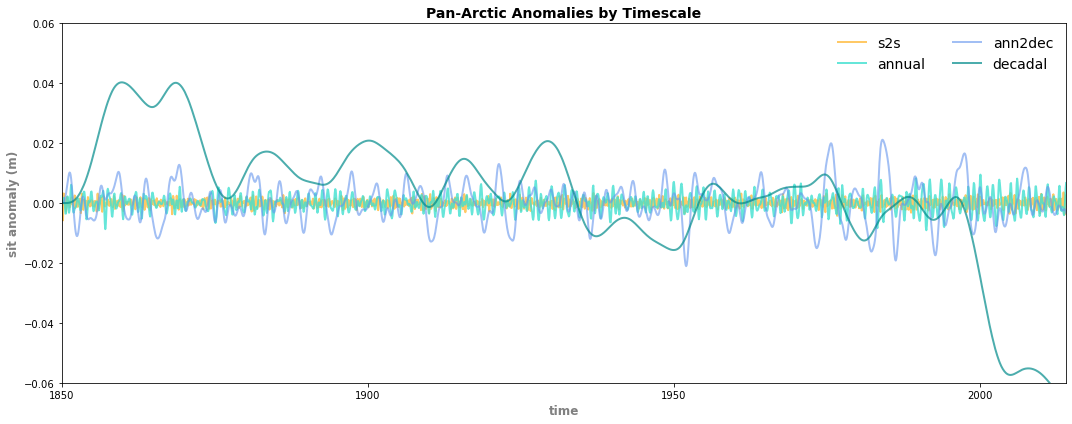

In [18]:
plt.figure(figsize=(15,6))
plt.plot(s2s_filtered.time, s2s_filtered.mean(dim=['ni','nj']), c='orange', alpha=0.6, linewidth=2)
plt.plot(annual_filtered.time, annual_filtered.mean(dim=['ni','nj']), c='turquoise', alpha=0.8,linewidth=2)
plt.plot(ann2dec_filtered.time, ann2dec_filtered.mean(dim=['ni','nj']), c='cornflowerblue', alpha=0.6,linewidth=2)
plt.plot(decadal_filtered.time, decadal_filtered.mean(dim=['ni','nj']), c='darkcyan', alpha=0.7,linewidth=2)
plt.xlim([-150*365, 14*365])
plt.ylim([-0.06, 0.06])
plt.ylabel('sit anomaly (m)', fontsize=12, fontweight='bold', color='grey')
plt.xlabel('time', fontsize=12, fontweight='bold', color='grey')
plt.legend(['s2s','annual','ann2dec','decadal'], fontsize=14, ncol=2, frameon=False)
plt.title('Pan-Arctic Anomalies by Timescale', fontweight='bold', fontsize=14)
plt.tight_layout()

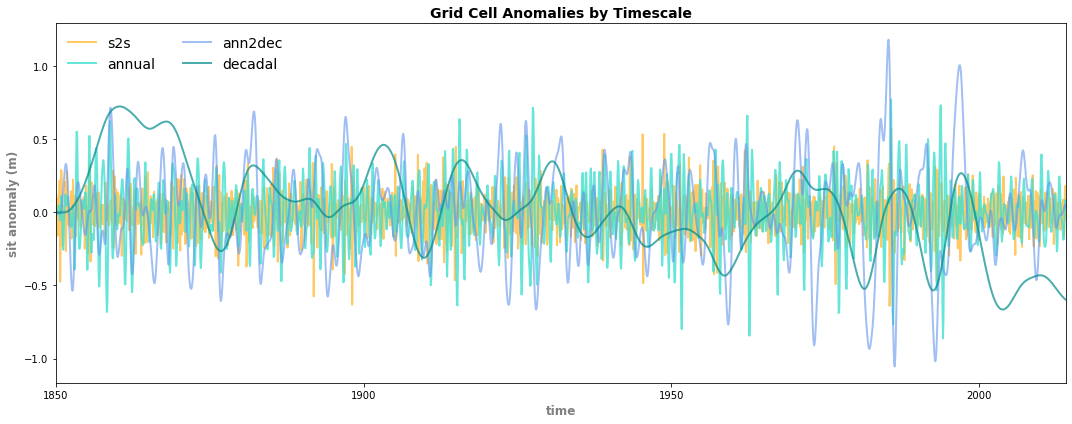

In [19]:
plt.figure(figsize=(15,6))
plt.plot(s2s_filtered.time, s2s_filtered[:, 375, 95], c='orange', alpha=0.6, linewidth=2)
plt.plot(annual_filtered.time, annual_filtered[:, 375, 95], c='turquoise', alpha=0.8,linewidth=2)
plt.plot(ann2dec_filtered.time, ann2dec_filtered[:, 375, 95], c='cornflowerblue', alpha=0.6,linewidth=2)
plt.plot(decadal_filtered.time, decadal_filtered[:, 375, 95], c='darkcyan', alpha=0.7,linewidth=2)
plt.xlim([-150*365, 14*365])
# plt.ylim([-0.06, 0.06])
plt.ylabel('sit anomaly (m)', fontsize=12, fontweight='bold', color='grey')
plt.xlabel('time', fontsize=12, fontweight='bold', color='grey')
plt.legend(['s2s','annual','ann2dec','decadal'], fontsize=14, ncol=2, frameon=False)
plt.title('Grid Cell Anomalies by Timescale', fontweight='bold', fontsize=14)
plt.tight_layout()

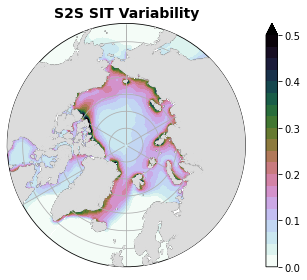

In [16]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(s2s_filtered.TLAT, s2s_filtered.TLON, s2s_filtered.std(dim='time'), ccrs.NorthPolarStereo())
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 0.5, 6)
clevs = np.linspace(0, 0.5, 21)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
plt.title('S2S SIT Variability', fontweight='bold', fontsize=14)
plt.tight_layout()

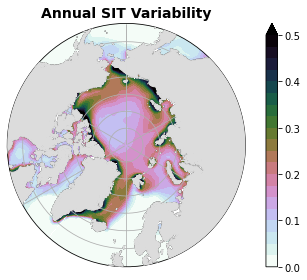

In [17]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(annual_filtered.TLAT, annual_filtered.TLON, annual_filtered.std(dim='time'), ccrs.NorthPolarStereo())
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 0.5, 6)
clevs = np.linspace(0, 0.5, 21)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
plt.title('Annual SIT Variability', fontweight='bold', fontsize=14)
plt.tight_layout()

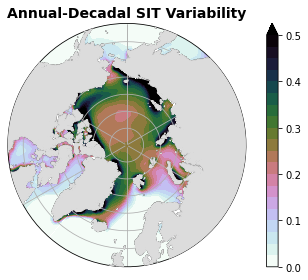

In [18]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(ann2dec_filtered.TLAT, ann2dec_filtered.TLON, ann2dec_filtered.std(dim='time'), ccrs.NorthPolarStereo())
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 0.5, 6)
clevs = np.linspace(0, 0.5, 21)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
plt.title('Annual-Decadal SIT Variability', fontweight='bold', fontsize=14)
plt.tight_layout()

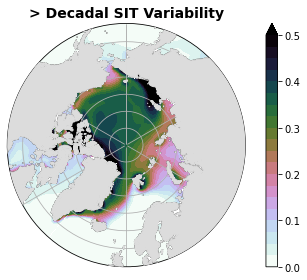

In [19]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(decadal_filtered.TLAT, decadal_filtered.TLON, decadal_filtered.std(dim='time'), ccrs.NorthPolarStereo())
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 0.5, 6)
clevs = np.linspace(0, 0.5, 21)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
plt.title('> Decadal SIT Variability', fontweight='bold', fontsize=14)
plt.tight_layout()

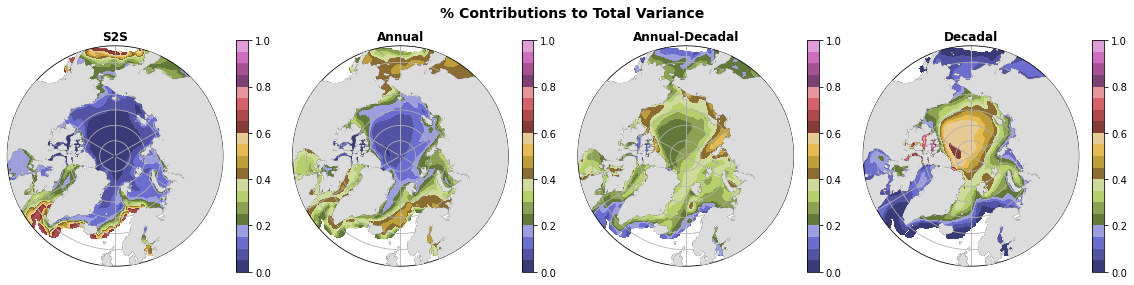

In [62]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), subplot_kw={'projection': ccrs.NorthPolarStereo()})
nps = ccrs.NorthPolarStereo()

ratio_s2s = s2s_filtered.var(dim='time')/anomalies.var(dim='time')
ratio_ann = annual_filtered.var(dim='time')/anomalies.var(dim='time')
ratio_a2d = ann2dec_filtered.var(dim='time')/anomalies.var(dim='time')
ratio_dec = decadal_filtered.var(dim='time')/anomalies.var(dim='time')

ratios = {'s2s':ratio_s2s, 'ann':ratio_ann, 'a2d':ratio_a2d, 'dec':ratio_dec}
tags = ['s2s','ann','a2d','dec']
titles = ['S2S', 'Annual', 'Annual-Decadal', 'Decadal']

for i in range(0, 4):
    fashion_space(axes[i])
    xs, ys, data_to_plot = convert_coords(s2s_filtered.TLAT, s2s_filtered.TLON, ratios[tags[i]], ccrs.NorthPolarStereo())
    cmap = plt.cm.tab20b
    clevs_label = np.linspace(0, 1, 6)
    clevs = np.linspace(0, 1, 21)
    img = axes[i].contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap)
    cbar2 = fig.colorbar(img, ax=axes[i], ticks= clevs_label)
    axes[i].set_title(titles[i], fontweight='bold', fontsize=12)

plt.suptitle('% Contributions to Total Variance', fontsize=14, fontweight='bold')
plt.tight_layout()

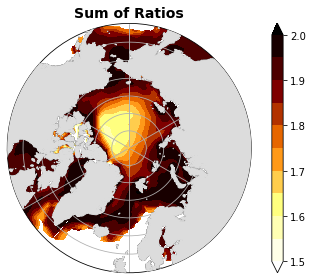

In [87]:
sum_ratios = ratio_s2s + ratio_ann + ratio_a2d + ratio_dec

fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(decadal_filtered.TLAT, decadal_filtered.TLON, sum_ratios, ccrs.NorthPolarStereo())
cmap = plt.cm.afmhot_r
clevs_label = np.linspace(1.5, 2, 6)
clevs = np.linspace(1.5, 2, 11)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend='both')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
plt.title('Sum of Ratios', fontweight='bold', fontsize=14)
plt.tight_layout()

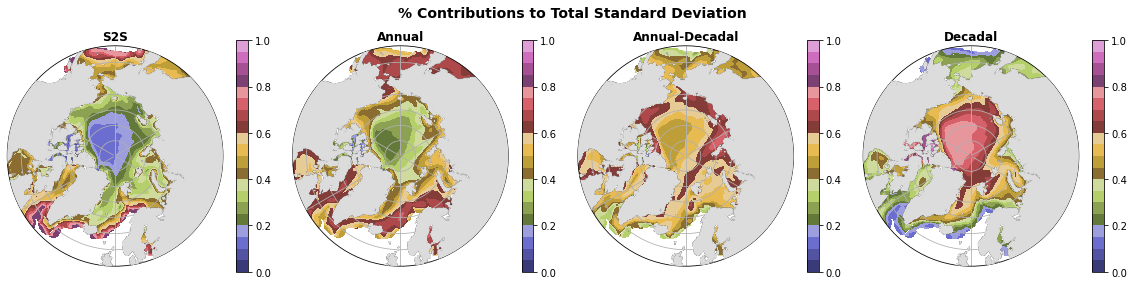

In [63]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), subplot_kw={'projection': ccrs.NorthPolarStereo()})
nps = ccrs.NorthPolarStereo()

ratio_s2s = s2s_filtered.std(dim='time')/anomalies.std(dim='time')
ratio_ann = annual_filtered.std(dim='time')/anomalies.std(dim='time')
ratio_a2d = ann2dec_filtered.std(dim='time')/anomalies.std(dim='time')
ratio_dec = decadal_filtered.std(dim='time')/anomalies.std(dim='time')

ratios = {'s2s':ratio_s2s, 'ann':ratio_ann, 'a2d':ratio_a2d, 'dec':ratio_dec}
tags = ['s2s','ann','a2d','dec']
titles = ['S2S', 'Annual', 'Annual-Decadal', 'Decadal']

for i in range(0, 4):
    fashion_space(axes[i])
    xs, ys, data_to_plot = convert_coords(s2s_filtered.TLAT, s2s_filtered.TLON, ratios[tags[i]], ccrs.NorthPolarStereo())
    cmap = plt.cm.tab20b
    clevs_label = np.linspace(0, 1, 6)
    clevs = np.linspace(0, 1, 21)
    img = axes[i].contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap)
    cbar2 = fig.colorbar(img, ax=axes[i], ticks= clevs_label)
    axes[i].set_title(titles[i], fontweight='bold', fontsize=12)

plt.suptitle('% Contributions to Total Standard Deviation', fontsize=14, fontweight='bold')
plt.tight_layout()

## Spectral Analysis of Filtered Timeseries

In [18]:
import scipy.signal as signal
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


In [23]:
s2s_freq, s2s_PSD = signal.welch(s2s_filtered.mean(dim=['ni','nj']),
                                 fs=1,
                                 window='hann',
                                 nperseg=512,
                                 detrend=False,
                                 axis=0
                                 )

ann_freq, ann_PSD = signal.welch(annual_filtered.mean(dim=['ni', 'nj']),
                                 fs=1,
                                 window='hann',
                                 nperseg=512,
                                 detrend=False,
                                 axis=0
                                 )

a2d_freq, a2d_PSD = signal.welch(ann2dec_filtered.mean(dim=['ni', 'nj']),
                                 fs=1,
                                 window='hann',
                                 nperseg=512,
                                 detrend=False,
                                 axis=0
                                 )

dec_freq, dec_PSD = signal.welch(decadal_filtered.mean(dim=['ni', 'nj']),
                                 fs=1,
                                 window='hann',
                                 nperseg=512,
                                 detrend=True,
                                 axis=0
                                 )

ValueError: Trend type must be 'linear' or 'constant'.

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launche

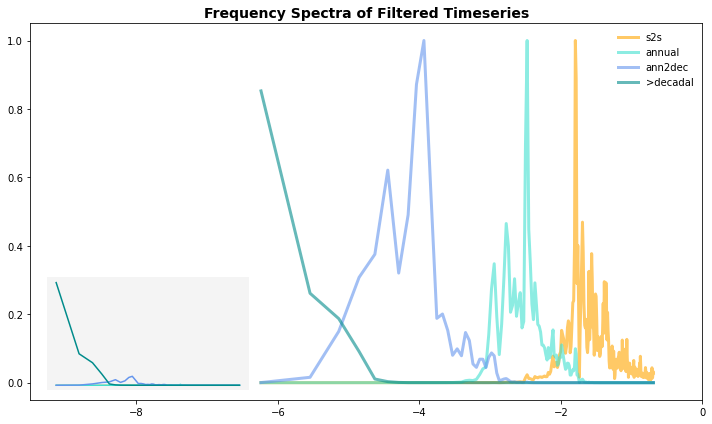

In [20]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(np.log(s2s_freq),
         s2s_PSD/max(s2s_PSD),
         color='orange',
         linewidth=3,
         alpha=0.6,
         label='s2s')

ax1.plot(np.log(ann_freq),
         ann_PSD/max(ann_PSD),
         color='turquoise',
         linewidth=3,
         alpha=0.6,
         label='annual',)

ax1.plot(np.log(a2d_freq),
         a2d_PSD/max(a2d_PSD),
         color='cornflowerblue',
         linewidth=3,
         alpha=0.6,
         label='ann2dec')

ax1.plot(np.log(dec_freq),
         dec_PSD/max(dec_PSD),
         color='darkcyan',
         linewidth=3,
         alpha=0.6,
         label='>decadal')

ax1.set_xlim([-9.5, 0])

ax1.legend(frameon=False)

ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.025,0.025,0.3,0.3])
ax2.set_axes_locator(ip)
ax2.plot(np.log(s2s_freq),
         s2s_PSD,
         color='orange',
         linewidth=1)
ax2.plot(np.log(ann_freq),
         ann_PSD,
         color='turquoise',
         linewidth=1.5
         )
ax2.plot(np.log(a2d_freq),
         a2d_PSD,
         color='cornflowerblue',
         linewidth=1.5
         )
ax2.plot(np.log(dec_freq),
         dec_PSD,
         color='darkcyan',
         linewidth=1.5
         )

ax2.patch.set_facecolor('gainsboro')
ax2.patch.set_alpha(0.3)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])

# for spine in ax2.spines.values():
#     spine.set_edgecolor('grey')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax1.set_title('Frequency Spectra of Filtered Timeseries', fontweight='bold', fontsize=14)
plt.tight_layout()

In [44]:
s2s_freq, s2s_PSD = signal.welch(s2s_filtered[:,375,95],
                                 fs=1,
                                 window='hann',
                                 nperseg=512,
                                 detrend=False,
                                 axis=0
                                 )

ann_freq, ann_PSD = signal.welch(annual_filtered[:,375,95],
                                 fs=1,
                                 window='hann',
                                 nperseg=512,
                                 detrend=False,
                                 axis=0
                                 )

a2d_freq, a2d_PSD = signal.welch(ann2dec_filtered[:,375,95],
                                 fs=1,
                                 window='hann',
                                 nperseg=512,
                                 detrend=False,
                                 axis=0
                                 )

dec_freq, dec_PSD = signal.welch(decadal_filtered[:,375,95],
                                 fs=1,
                                 window='hann',
                                 nperseg=512,
                                 detrend=False,
                                 axis=0
                                 )

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launche

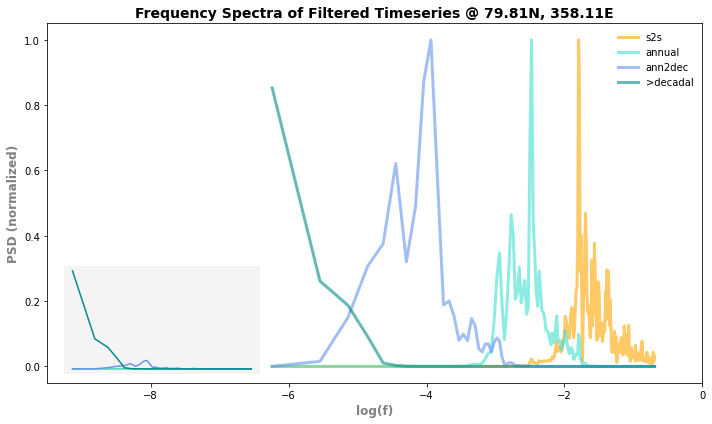

In [24]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(np.log(s2s_freq),
         s2s_PSD/max(s2s_PSD),
         color='orange',
         linewidth=3,
         alpha=0.6,
         label='s2s')

ax1.plot(np.log(ann_freq),
         ann_PSD/max(ann_PSD),
         color='turquoise',
         linewidth=3,
         alpha=0.6,
         label='annual',)

ax1.plot(np.log(a2d_freq),
         a2d_PSD/max(a2d_PSD),
         color='cornflowerblue',
         linewidth=3,
         alpha=0.6,
         label='ann2dec')

ax1.plot(np.log(dec_freq),
         dec_PSD/max(dec_PSD),
         color='darkcyan',
         linewidth=3,
         alpha=0.6,
         label='>decadal')

ax1.set_xlim([-9.5, 0])

ax1.legend(frameon=False)

ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.025,0.025,0.3,0.3])
ax2.set_axes_locator(ip)
ax2.plot(np.log(s2s_freq),
         s2s_PSD,
         color='orange',
         linewidth=1)
ax2.plot(np.log(ann_freq),
         ann_PSD,
         color='turquoise',
         linewidth=1.5
         )
ax2.plot(np.log(a2d_freq),
         a2d_PSD,
         color='cornflowerblue',
         linewidth=1.5
         )
ax2.plot(np.log(dec_freq),
         dec_PSD,
         color='darkcyan',
         linewidth=1.5
         )

ax2.patch.set_facecolor('gainsboro')
ax2.patch.set_alpha(0.3)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])

# for spine in ax2.spines.values():
#     spine.set_edgecolor('grey')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

lat = np.round(s2s_filtered.TLAT[375,96].values,2)
lon = np.round(s2s_filtered.TLON[375,96].values,2)

ax1.set_title('Frequency Spectra of Filtered Timeseries @ '+ str(lat) + 'N, ' + str(lon)+'E', fontweight='bold', fontsize=14)
ax1.set_xlabel('log(f)', fontweight='bold', fontsize=12, color='grey')
ax1.set_ylabel('PSD (normalized)', fontweight='bold', fontsize=12, color='grey')
plt.tight_layout()

In [ ]:
# IDEA: Lagrangian thickness tracers (forecasted for a few years)

In [32]:
dec_freq, dec_PSD = signal.welch(decadal_filtered,
                                 fs=1,
                                 window='hann',
                                 nperseg=512,
                                 detrend=False,
                                 axis=0
                                 )

a2d_freq, a2d_PSD = signal.welch(ann2dec_filtered,
                                 fs=1,
                                 window='hann',
                                 nperseg=512,
                                 detrend=False,
                                 axis=0
                                 )
ann_freq, ann_PSD = signal.welch(annual_filtered,
                                 fs=1,
                                 window='hann',
                                 nperseg=512,
                                 detrend=False,
                                 axis=0
                                 )
s2s_freq, s2s_PSD = signal.welch(ann2dec_filtered,
                                 fs=1,
                                 window='hann',
                                 nperseg=512,
                                 detrend=False,
                                 axis=0
                                 )

In [66]:
np.shape(dec_PSD.mean(axis=1))

(513, 320)

In [33]:
norm_dec = dec_PSD.reshape(np.shape(dec_PSD)[0], 384*320).transpose()/np.nanmax(dec_PSD, axis=(1,2))
norm_a2d = a2d_PSD.reshape(np.shape(a2d_PSD)[0], 384*320).transpose()/np.nanmax(a2d_PSD, axis=(1,2))
norm_ann = ann_PSD.reshape(np.shape(ann_PSD)[0], 384*320).transpose()/np.nanmax(ann_PSD, axis=(1,2))
norm_s2s = s2s_PSD.reshape(np.shape(s2s_PSD)[0], 384*320).transpose()/np.nanmax(s2s_PSD, axis=(1,2))

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


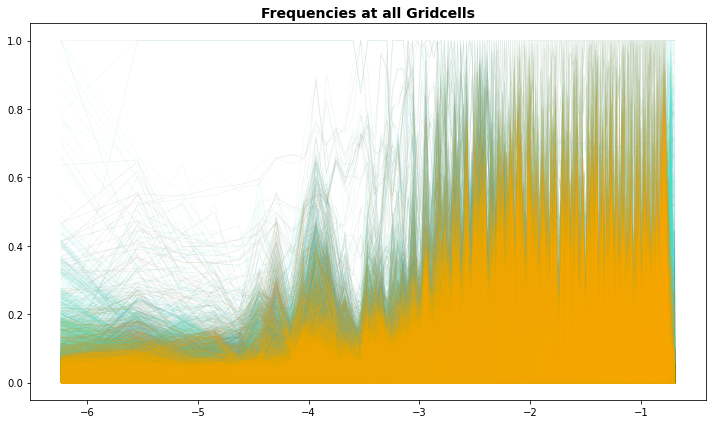

In [35]:
fig = plt.subplots(figsize=(10,6))
plt.plot(np.log(dec_freq), norm_dec.transpose(),
         color='darkcyan', linewidth=0.5, alpha=0.1)
plt.plot(np.log(a2d_freq), norm_a2d.transpose(),
         color='cornflowerblue', linewidth=0.5, alpha=0.1)
plt.plot(np.log(ann_freq), norm_ann.transpose(),
         color='turquoise', linewidth=0.5, alpha=0.1)
plt.plot(np.log(s2s_freq), norm_s2s.transpose(),
         color='orange', linewidth=0.5, alpha=0.1)
plt.title('Frequencies at all Gridcells',fontweight='bold',fontsize=14)
plt.tight_layout()

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


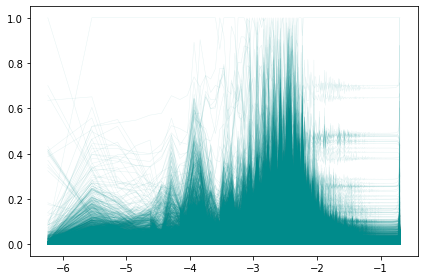

In [38]:
plt.plot(np.log(dec_freq), norm_dec.transpose(),
         color='darkcyan', linewidth=0.5, alpha=0.1)
plt.tight_layout()

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


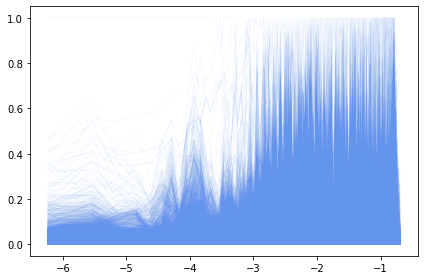

In [39]:
plt.plot(np.log(a2d_freq), norm_a2d.transpose(),
         color='cornflowerblue', linewidth=0.5, alpha=0.1)
plt.tight_layout()

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


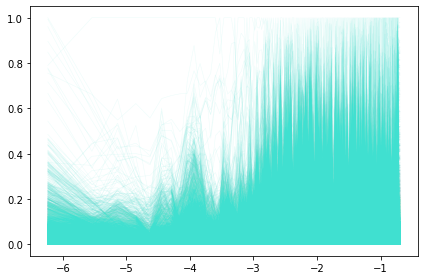

In [40]:
plt.plot(np.log(ann_freq), norm_ann.transpose(),
         color='turquoise', linewidth=0.5, alpha=0.1)
plt.tight_layout()

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


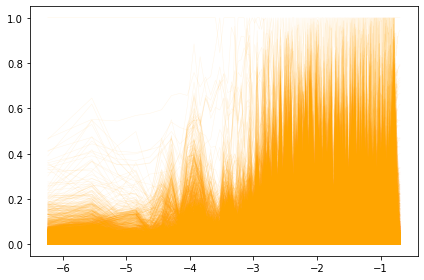

In [41]:
plt.plot(np.log(s2s_freq), norm_s2s.transpose(),
         color='orange', linewidth=0.5, alpha=0.1)
plt.tight_layout()